# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout forward pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [3]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



# Dropout backward pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [4]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

**Answer:** The gradients in the `train` mode are still computed by the same formula (`dx = dout * mask`) within `layers.py`, because the `mask` tensor includes scaling by `p` or its absence (i.e., being either 0 and 1/p valued, or 0 and 1 valued respectively). The gradients in the `test` mode would change however by a multiplicative factor of `p` (although the `test` mode gradients are never used, so this is not really relevant).

# Fully-connected nets with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specifically, if the constructor of the net receives a value that is not 1 for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [5]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Relative errors should be around e-6 or less; Note that it's fine
  # if for dropout=1 you have W2 error be on the order of e-5.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  1
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.75
Initial loss:  2.302371489704412
W1 relative error: 1.90e-07
W2 relative error: 4.76e-06
W3 relative error: 2.60e-08
b1 relative error: 4.73e-09
b2 relative error: 1.82e-09
b3 relative error: 1.70e-10

Running check with dropout =  0.5
Initial loss:  2.3042759220785896
W1 relative error: 3.11e-07
W2 relative error: 1.84e-08
W3 relative error: 5.35e-08
b1 relative error: 2.58e-08
b2 relative error: 2.99e-09
b3 relative error: 1.13e-10



# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a keep probability of 0.25. We will then visualize the training and validation accuracies of the two networks over time.

In [6]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=50, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

1
(Iteration 1 / 500) loss: 7.622525
(Epoch 0 / 50) train acc: 0.191000; val_acc: 0.158000
(Epoch 1 / 50) train acc: 0.400000; val_acc: 0.239000
(Epoch 2 / 50) train acc: 0.454000; val_acc: 0.257000
(Epoch 3 / 50) train acc: 0.597000; val_acc: 0.268000
(Epoch 4 / 50) train acc: 0.663000; val_acc: 0.288000
(Epoch 5 / 50) train acc: 0.727000; val_acc: 0.282000
(Epoch 6 / 50) train acc: 0.754000; val_acc: 0.299000
(Epoch 7 / 50) train acc: 0.791000; val_acc: 0.309000
(Epoch 8 / 50) train acc: 0.834000; val_acc: 0.331000
(Epoch 9 / 50) train acc: 0.848000; val_acc: 0.323000
(Epoch 10 / 50) train acc: 0.884000; val_acc: 0.332000
(Iteration 101 / 500) loss: 0.807858
(Epoch 11 / 50) train acc: 0.904000; val_acc: 0.327000
(Epoch 12 / 50) train acc: 0.911000; val_acc: 0.339000
(Epoch 13 / 50) train acc: 0.922000; val_acc: 0.322000
(Epoch 14 / 50) train acc: 0.949000; val_acc: 0.306000
(Epoch 15 / 50) train acc: 0.972000; val_acc: 0.353000
(Epoch 16 / 50) train acc: 0.968000; val_acc: 0.333000
(

(Epoch 38 / 50) train acc: 0.942000; val_acc: 0.330000
(Epoch 39 / 50) train acc: 0.924000; val_acc: 0.322000
(Epoch 40 / 50) train acc: 0.939000; val_acc: 0.320000
(Iteration 401 / 500) loss: 1.741452
(Epoch 41 / 50) train acc: 0.908000; val_acc: 0.321000
(Epoch 42 / 50) train acc: 0.947000; val_acc: 0.313000
(Epoch 43 / 50) train acc: 0.958000; val_acc: 0.323000
(Epoch 44 / 50) train acc: 0.954000; val_acc: 0.345000
(Epoch 45 / 50) train acc: 0.943000; val_acc: 0.339000
(Epoch 46 / 50) train acc: 0.954000; val_acc: 0.336000
(Epoch 47 / 50) train acc: 0.961000; val_acc: 0.322000
(Epoch 48 / 50) train acc: 0.951000; val_acc: 0.336000
(Epoch 49 / 50) train acc: 0.959000; val_acc: 0.324000
(Epoch 50 / 50) train acc: 0.958000; val_acc: 0.340000
0.25
(Iteration 1 / 500) loss: 15.176442
(Epoch 0 / 50) train acc: 0.196000; val_acc: 0.170000
(Epoch 1 / 50) train acc: 0.387000; val_acc: 0.305000
(Epoch 2 / 50) train acc: 0.450000; val_acc: 0.319000
(Epoch 3 / 50) train acc: 0.498000; val_acc: 

(Epoch 25 / 50) train acc: 0.528000; val_acc: 0.323000
(Epoch 26 / 50) train acc: 0.489000; val_acc: 0.327000
(Epoch 27 / 50) train acc: 0.535000; val_acc: 0.343000
(Epoch 28 / 50) train acc: 0.526000; val_acc: 0.329000
(Epoch 29 / 50) train acc: 0.528000; val_acc: 0.329000
(Epoch 30 / 50) train acc: 0.547000; val_acc: 0.341000
(Iteration 301 / 500) loss: 6.097468
(Epoch 31 / 50) train acc: 0.509000; val_acc: 0.301000
(Epoch 32 / 50) train acc: 0.522000; val_acc: 0.321000
(Epoch 33 / 50) train acc: 0.535000; val_acc: 0.312000
(Epoch 34 / 50) train acc: 0.518000; val_acc: 0.309000
(Epoch 35 / 50) train acc: 0.529000; val_acc: 0.352000
(Epoch 36 / 50) train acc: 0.529000; val_acc: 0.342000
(Epoch 37 / 50) train acc: 0.542000; val_acc: 0.323000
(Epoch 38 / 50) train acc: 0.509000; val_acc: 0.338000
(Epoch 39 / 50) train acc: 0.546000; val_acc: 0.330000
(Epoch 40 / 50) train acc: 0.522000; val_acc: 0.328000
(Iteration 401 / 500) loss: 6.321488
(Epoch 41 / 50) train acc: 0.524000; val_acc: 

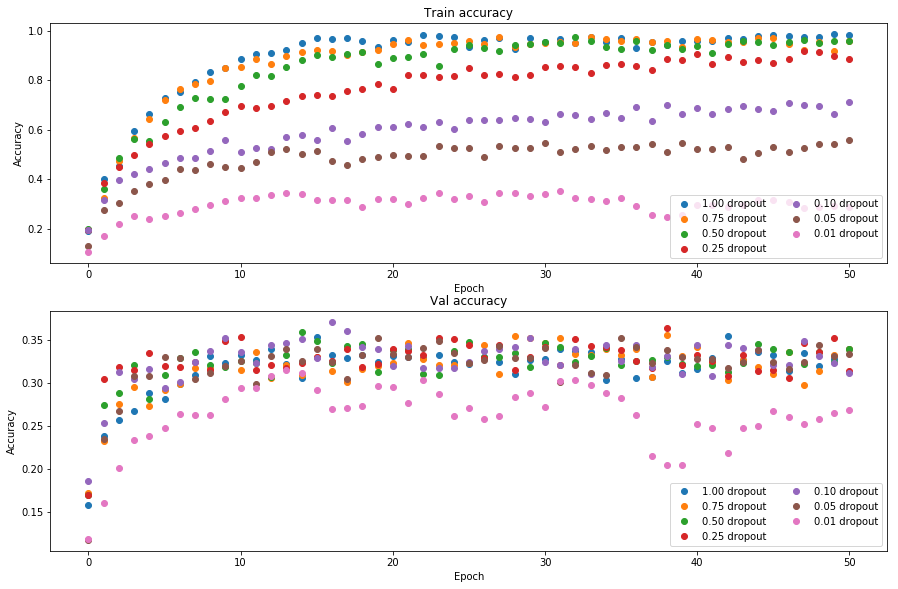

In [7]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

## Answer:

It seems that dropout reduces overfitting to the training data (i.e., reduces the gap between training and validation accuracy), and may indeed improve accuracy on the validation set.

For the implemented *inverted* dropout, the smaller the value of p the more activations are set to zero. The training accuracy decreases with p. Very small p (i.e., too much dropout; too much regularization) results in reduced validation accuracy.

## Inline Question 3:
Suppose we are training a deep fully-connected network for image classification, with dropout after hidden layers (parameterized by keep probability p). How should we modify p, if at all, if we decide to decrease the size of the hidden layers (that is, the number of nodes in each layer)?

## Answer:


Probably in that case we need to increase p (the "keep probability"), in order to have "enough" active hidden units in each forward pass.